# Model 6b - MLPClassifier with standardization

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score, r2_score, mean_squared_error

from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Safety Factor Class,Safety Factor Class_1,Safety Factor Class_2,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),Length Line of Intersection (m),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,11.0,6.0,1.05,6349.248707,171.429715,31.846178,161.418240,56.856884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,13.0,7.0,1.35,7701.148241,207.931003,31.905513,168.542870,56.762278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,9.0,5.0,0.75,2341.641868,63.224330,36.973415,150.874977,49.879923,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,7.0,4.0,0.75,155.345062,4.194317,54.969435,195.219985,36.636928,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,13.0,7.0,1.35,7468.340623,201.645197,29.688564,178.765625,60.571151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 90)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Safety Factor Class_2","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 9)


,Safety Factor Class_2,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,1.05,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,1.35,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,0.75,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,0.75,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,1.35,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 9)


In [6]:
data_model['Safety Factor Class_2'] = data_model['Safety Factor Class_2'].apply(str)

## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split. Classification (accuracy and f1-score) and pseudo-regression (r2 and rmse) are performed. For pseudo-regression, the average value of the predicted class is compared with the actual (numeric) safety factor value.

In [7]:
num_samples = []

accuracy_train_subsample_list = []
f1_train_subsample_list = []
accuracy_test_subsample_list = []
f1_test_subsample_list = []

r2_train_subsample_list = []
r2_test_subsample_list = []
rmse_train_subsample_list = []
rmse_test_subsample_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    # dataset up to 4950 points
    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        # train/test split with different random_state values (0, 1, 42, and 123)
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Safety Factor Class_2"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Safety Factor Class_2"]].values
        y_test_subsample = np.ravel(y_test_subsample)

        # train basic mlp model with default hyperparameters
        # make pipeline for mlp with pre-processing (standardizing the data)
        pipe_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=123))
        pipe_mlp.fit(x_train_subsample, y_train_subsample)

        ypred_mlp = pipe_mlp.predict(x_train_subsample)
        ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))

        # training accuracy, f1, r2, and rmse
        accuracy_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
        f1_train_subsample = f1_score(y_train_subsample,ypred_mlp,average='macro')

        r2_train_subsample = r2_score(y_train_subsample,ypred_mlp)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_mlp))
        
        # append training accuracy, f1, r2, and rmse to their respective lists
        accuracy_train_subsample_list.append(accuracy_train_subsample)
        f1_train_subsample_list.append(f1_train_subsample)
       
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
    
        # test the mlp model
        # predict y test
        ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
        ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))

        # test accuracy, f1, r2, and rmse
        accuracy_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
        f1_test_subsample = f1_score(y_test_subsample,ypred_test_mlp,average='macro')

        r2_test_subsample = r2_score(y_test_subsample,ypred_test_mlp)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_mlp))
        
        # append test accuracy, f1, r2, and rmse to their respective lists
        accuracy_test_subsample_list.append(accuracy_test_subsample)
        f1_test_subsample_list.append(f1_test_subsample)
        
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
    
    # entire dataset (4955 points)
    num_samples.append(len(data_model.index))

    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123)
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])
    
    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Safety Factor Class_2"]]
    y_train_subsample = np.ravel(y_train_subsample)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Safety Factor Class_2"]]
    y_test_subsample = np.ravel(y_test_subsample)

    # train basic mlp model with default hyperparameters
    # make pipeline for mlp with pre-processing (standardizing the data)
    pipe_mlp = make_pipeline(StandardScaler(), MLPClassifier(random_state=123))
    pipe_mlp.fit(x_train_subsample, y_train_subsample)

    ypred_mlp = pipe_mlp.predict(x_train_subsample)
    ypred_mlp = np.reshape(ypred_mlp,(len(ypred_mlp),1))

    # training accuracy, f1, r2, and rmse
    accuracy_train_subsample = pipe_mlp.score(x_train_subsample,y_train_subsample)
    f1_train_subsample = f1_score(y_train_subsample,ypred_mlp,average='macro')

    r2_train_subsample = r2_score(y_train_subsample,ypred_mlp)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_mlp))

    # append training accuracy, f1, r2, and rmse to their respective lists
    accuracy_train_subsample_list.append(accuracy_train_subsample)
    f1_train_subsample_list.append(f1_train_subsample)

    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)

    # test the mlp model
    # predict mlp test
    ypred_test_mlp = pipe_mlp.predict(x_test_subsample)
    ypred_test_mlp = np.reshape(ypred_test_mlp,(len(ypred_test_mlp),1))

    # test accuracy, f1, r2, and rmse
    accuracy_test_subsample = pipe_mlp.score(x_test_subsample,y_test_subsample)
    f1_test_subsample = f1_score(y_test_subsample,ypred_test_mlp,average='macro')

    r2_test_subsample = r2_score(y_test_subsample,ypred_test_mlp)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_mlp))

    # append test accuracy, f1, r2, and rmse to their respective lists
    accuracy_test_subsample_list.append(accuracy_test_subsample)
    f1_test_subsample_list.append(f1_test_subsample)

    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)


C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

C:\Users\bever\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\Users\bever\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:96: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_pred = check_array(y_pred, ensure_2d=False, dtype=dtype)
C:\U

In [8]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)
accuracy_train_subsample_list = pd.DataFrame(accuracy_train_subsample_list)
f1_train_subsample_list = pd.DataFrame(f1_train_subsample_list)
accuracy_test_subsample_list = pd.DataFrame(accuracy_test_subsample_list)
f1_test_subsample_list = pd.DataFrame(f1_test_subsample_list)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)

In [9]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,accuracy_train_subsample_list,f1_train_subsample_list,r2_train_subsample_list,rmse_train_subsample_list,accuracy_test_subsample_list,f1_test_subsample_list,r2_test_subsample_list,rmse_test_subsample_list],axis=1)

In [10]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
print(random_state_len)
print(max(np.shape(rslts)))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

99
396


,0,0,0,0,0,0,0,0,0
391,4800,0.953385,0.826396,0.974046,0.070950,0.926042,0.760930,0.955815,0.087916
392,4850,0.957990,0.843883,0.977201,0.066542,0.901031,0.654665,0.933259,0.108314
393,4900,0.960204,0.840615,0.977694,0.065426,0.912245,0.657375,0.949056,0.096309
394,4950,0.956566,0.843590,0.975501,0.068424,0.912121,0.691386,0.950818,0.094868
395,4992,0.956424,0.841950,0.975528,0.068762,0.901902,0.656826,0.943250,0.100350


In [11]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','accuracy_train_subsample','f1_train_subsample','r2_train_subsample','rmse_train_subsample','accuracy_test_subsample','f1_test_subsample','r2_test_subsample','rmse_test_subsample'])


In [12]:
randomstate123_rslts_pd.tail()

,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample
94,4800.0,0.953385,0.826396,0.974046,0.070950,0.926042,0.760930,0.955815,0.087916
95,4850.0,0.957990,0.843883,0.977201,0.066542,0.901031,0.654665,0.933259,0.108314
96,4900.0,0.960204,0.840615,0.977694,0.065426,0.912245,0.657375,0.949056,0.096309
97,4950.0,0.956566,0.843590,0.975501,0.068424,0.912121,0.691386,0.950818,0.094868
98,4992.0,0.956424,0.841950,0.975528,0.068762,0.901902,0.656826,0.943250,0.100350


(0.0, 1.0)

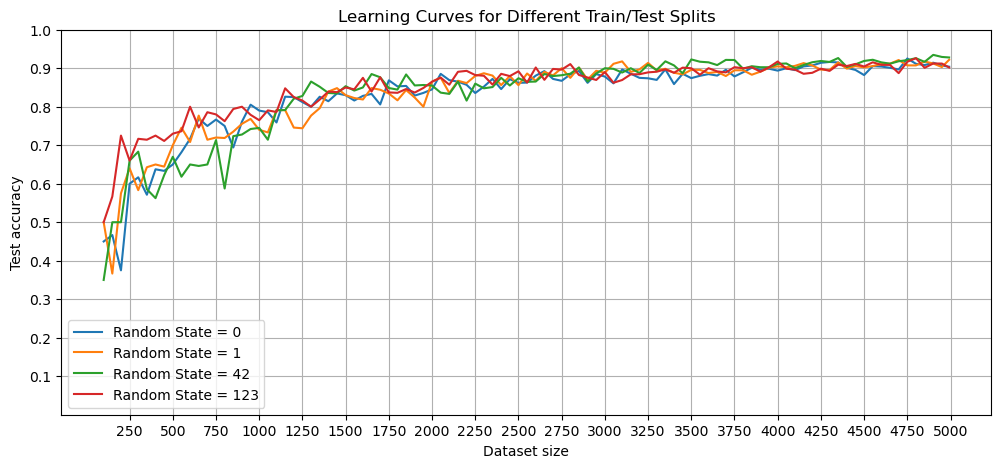

In [13]:
# plot learning curves for different train/test splits for test accuracy
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['accuracy_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['accuracy_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['accuracy_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['accuracy_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test accuracy')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x290ba988c70>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

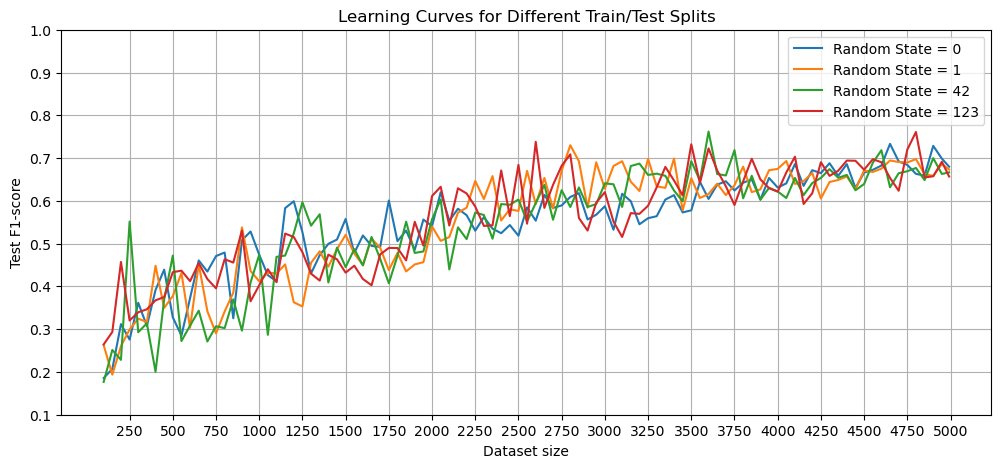

In [14]:
# plot learning curves for different train/test splits for test f1
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['f1_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['f1_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['f1_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['f1_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test F1-score')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290cc9c1d60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

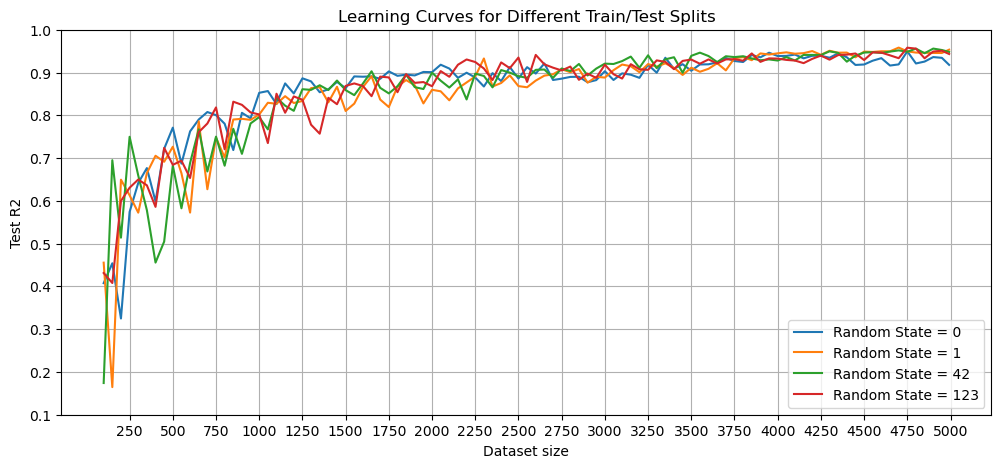

In [38]:
# plot learning curves for different train/test splits for test r2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['r2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['r2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['r2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['r2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290baa2c190>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

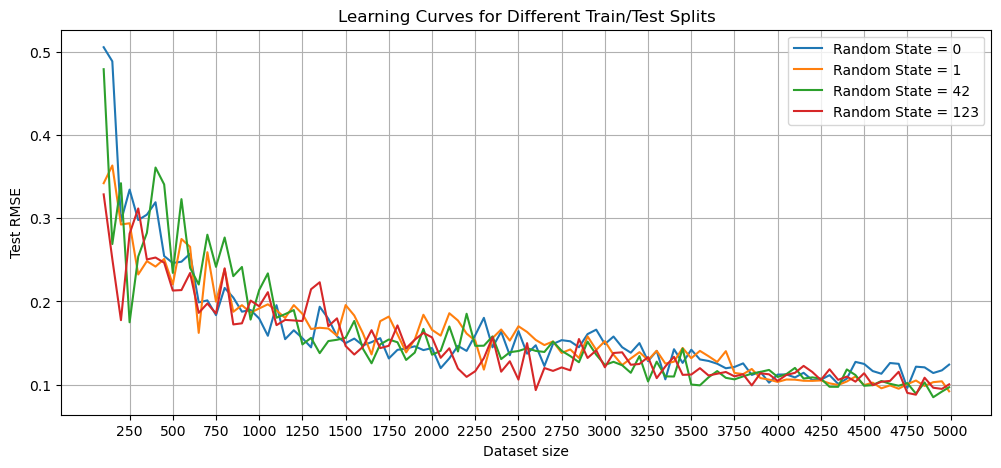

In [16]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290baa1f340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

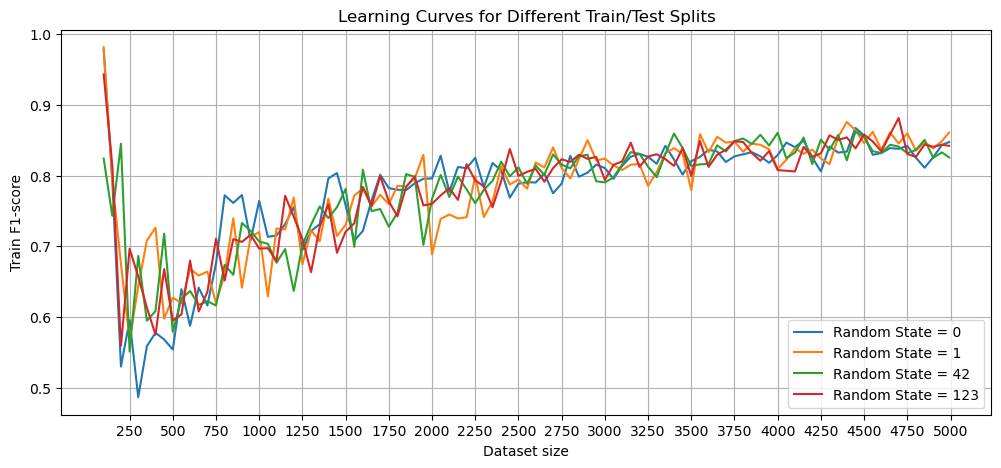

In [17]:
# plot learning curves for different train/test splits for train f1
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['f1_train_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['f1_train_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['f1_train_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['f1_train_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Train F1-score')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [18]:
# train accuracy - test accuracy
randomstate0_accuracydiff = randomstate0_rslts_pd['accuracy_train_subsample'] - randomstate0_rslts_pd['accuracy_test_subsample']
randomstate1_accuracydiff = randomstate1_rslts_pd['accuracy_train_subsample'] - randomstate1_rslts_pd['accuracy_test_subsample']
randomstate42_accuracydiff = randomstate42_rslts_pd['accuracy_train_subsample'] - randomstate42_rslts_pd['accuracy_test_subsample']
randomstate123_accuracydiff = randomstate123_rslts_pd['accuracy_train_subsample'] - randomstate123_rslts_pd['accuracy_test_subsample']

# train f1 - test f1
randomstate0_f1diff = randomstate0_rslts_pd['f1_train_subsample'] - randomstate0_rslts_pd['f1_test_subsample']
randomstate1_f1diff = randomstate1_rslts_pd['f1_train_subsample'] - randomstate1_rslts_pd['f1_test_subsample']
randomstate42_f1diff = randomstate42_rslts_pd['f1_train_subsample'] - randomstate42_rslts_pd['f1_test_subsample']
randomstate123_f1diff = randomstate123_rslts_pd['f1_train_subsample'] - randomstate123_rslts_pd['f1_test_subsample']


# train r2 - test r2
randomstate0_r2diff = randomstate0_rslts_pd['r2_train_subsample'] - randomstate0_rslts_pd['r2_test_subsample']
randomstate1_r2diff = randomstate1_rslts_pd['r2_train_subsample'] - randomstate1_rslts_pd['r2_test_subsample']
randomstate42_r2diff = randomstate42_rslts_pd['r2_train_subsample'] - randomstate42_rslts_pd['r2_test_subsample']
randomstate123_r2diff = randomstate123_rslts_pd['r2_train_subsample'] - randomstate123_rslts_pd['r2_test_subsample']

# test rmse - train rmse
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']


([<matplotlib.axis.XTick at 0x290ba68fd60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

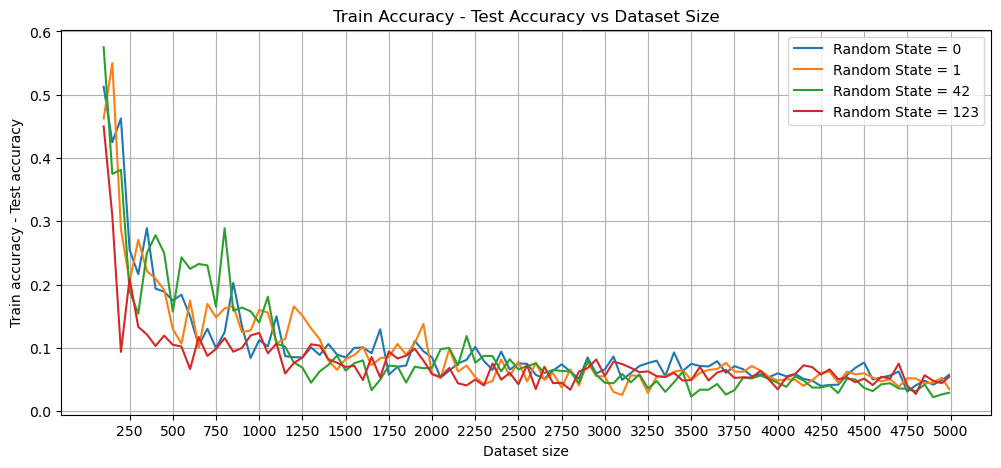

In [19]:
# plot accuracy diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_accuracydiff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_accuracydiff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_accuracydiff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_accuracydiff,label='Random State = 123')
plt.title('Train Accuracy - Test Accuracy vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train accuracy - Test accuracy')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290ba7017f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

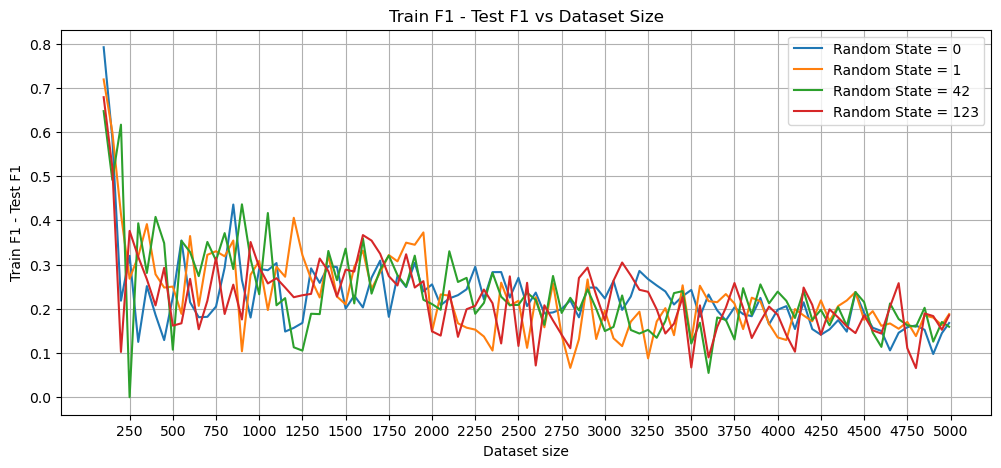

In [20]:
# plot f1 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_f1diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_f1diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_f1diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_f1diff,label='Random State = 123')
plt.title('Train F1 - Test F1 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train F1 - Test F1')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290bd7a2e80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

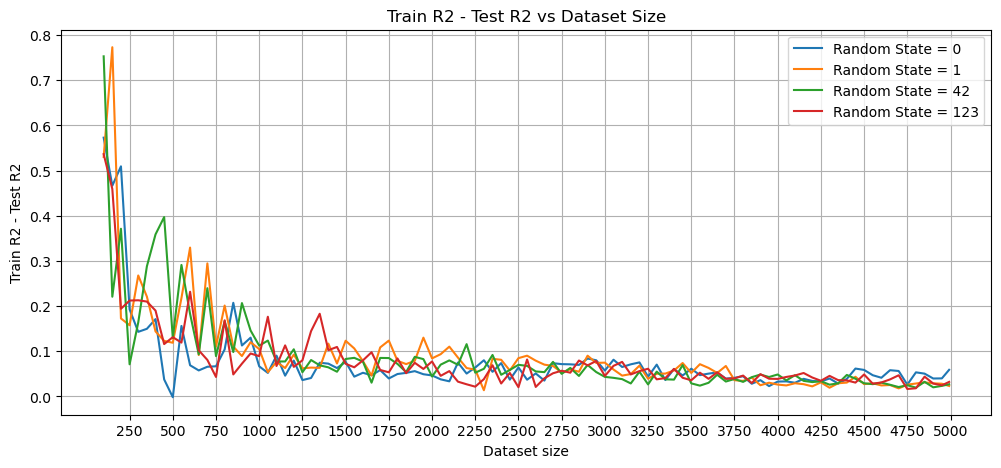

In [21]:
# plot r2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_r2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_r2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_r2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_r2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x290bd85b250>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

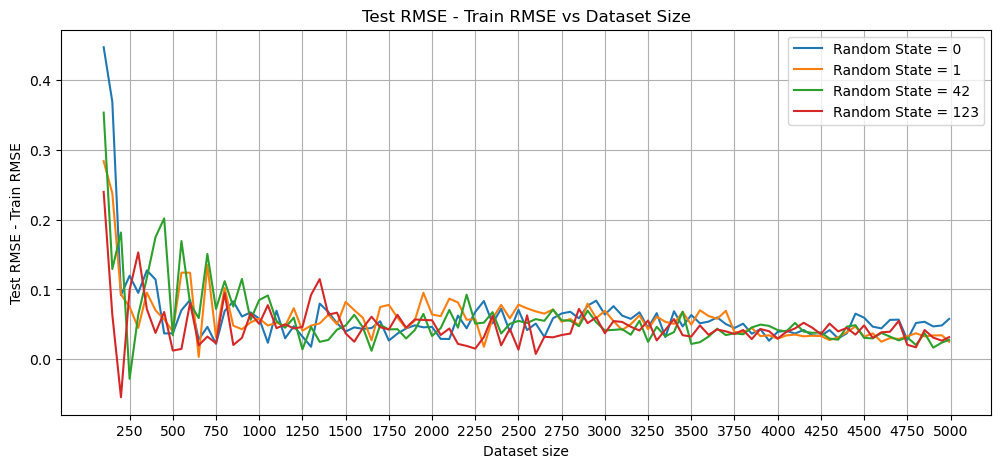

In [22]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [23]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample,num_samples,...,rmse_test_subsample,num_samples,accuracy_train_subsample,f1_train_subsample,r2_train_subsample,rmse_train_subsample,accuracy_test_subsample,f1_test_subsample,r2_test_subsample,rmse_test_subsample
0,100.0,0.962500,0.977703,0.980554,0.058095,0.450000,0.185714,0.407571,0.505470,100.0,...,0.479062,100.0,0.950000,0.943128,0.967772,0.088741,0.500000,0.264286,0.431280,0.328634
1,150.0,0.891667,0.793107,0.920685,0.119373,0.466667,0.206985,0.454046,0.488535,150.0,...,0.268949,150.0,0.875000,0.813702,0.867297,0.187305,0.566667,0.293487,0.407895,0.250998
2,200.0,0.837500,0.529791,0.834485,0.204328,0.375000,0.311688,0.324968,0.296226,200.0,...,0.342053,200.0,0.818750,0.559097,0.793897,0.232110,0.725000,0.457066,0.599714,0.177482
3,250.0,0.855000,0.595357,0.766931,0.214826,0.600000,0.275659,0.574121,0.334365,250.0,...,0.174929,250.0,0.870000,0.696437,0.843010,0.182209,0.660000,0.320265,0.630625,0.281425
4,300.0,0.833333,0.486381,0.784866,0.202690,0.616667,0.361591,0.641747,0.297769,300.0,...,0.253969,300.0,0.850000,0.656873,0.862827,0.158640,0.716667,0.339461,0.649846,0.311716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800.0,0.952604,0.825102,0.974540,0.069728,0.911458,0.663078,0.921087,0.121578,4800.0,...,0.089151,4800.0,0.953385,0.826396,0.974046,0.070950,0.926042,0.760930,0.955815,0.087916
95,4850.0,0.956443,0.810998,0.976128,0.067216,0.908247,0.658920,0.925546,0.120779,4850.0,...,0.102645,4850.0,0.957990,0.843883,0.977201,0.066542,0.901031,0.654665,0.933259,0.108314
96,4900.0,0.956378,0.825851,0.975881,0.067063,0.914286,0.728520,0.936060,0.113973,4900.0,...,0.084877,4900.0,0.960204,0.840615,0.977694,0.065426,0.912245,0.657375,0.949056,0.096309
97,4950.0,0.956061,0.843155,0.974328,0.068792,0.907071,0.698634,0.934252,0.117163,4950.0,...,0.091618,4950.0,0.956566,0.843590,0.975501,0.068424,0.912121,0.691386,0.950818,0.094868


In [24]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model6b_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model6b_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()